# Evaluation 9-5-24 Cours Deep-Life TME-solo-2

Nom: Liétar

Prénom: Simon

Numéro Etudiant: 21313900


# Consignes

## Document à rendre
Le Jupyter Notebook est le document à rendre. Il doit être rendu de manière à ce qu'il soit facile à lire, et qu'il soit facile de
repérer et de lire vos réponses. Si ce n'est pas le cas, des points vous seront retirés, ceci pouvant aller jusqu'à l'intégralité 
des points pour la question.
    

## Documents autorisés

Vous n'êtes pas autorisés à utiliser d'autres ressources que celles qui vous sont fournies sur Moodle.
Vous ne pouvez pas utiliser Internet autrement que pour accéder à Moodle. Si cette consigne n'est pas respectée,
cela signifie automatiquement un zéro pour votre copie. 


Aidez-vous de la fonction help(***), où *** doit être remplacé par l'objet,la fonction... pour lequel vous souhaitez avoir plus d'informations.

## Indication sur les fonctions et classes qui peuvent être utilisées:

- torch.nn.functional.relu
- torch.sigmoid
- nn.Linear
- torch.sigmoid
- matplotlib.pyplot.scatter
- numpy.linspace

#### Le bareme est donné à titre indicatif



In [1]:
import numpy as np
import torch.nn as nn
from sklearn.decomposition import PCA
from matplotlib import cm
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import torchvision
from torchvision import datasets, transforms


# Partie 0: Prétaitement du dataset

In [2]:
training_data= datasets.MNIST(root="data",train=True,download=True,transform=transforms.ToTensor())
test_data = datasets.MNIST(root="data",train=False,download=True,transform=transforms.ToTensor())


### Q1 (1pts)
Créez un jeu de données, training_data_small, qui ne contient que 1/6 des données de MNIST train, en vous assurant de respecter plus ou moins
les proportions des données par classes de MNIST train. Le jeu de données training_data_small que vous retournerez doit être constitué de
tenseurs (torch.Tensor) : c'est-à-dire que les images apparaissent en format torch.Tensor.


In [3]:
# Calcul de la longueur de training_data_small
training_data_small_len = len(training_data) // 6

# Création d'une permutation pour s'assurer que les proportions des classes soient conservées (en moyenne)
permutation = np.random.permutation(len(training_data))[:training_data_small_len]

# Filtrage des données
training_data_small = [training_data[item_index] for item_index in permutation]

# Affichage de la répartition des classes avant et après
print(np.bincount(training_data.targets))
print(np.bincount([cl for _, cl in training_data_small]))


[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
[ 973 1151 1015  997  917  932  975 1083  982  975]


# Partie I: Autoencodeur

### Q2 (3pts)
Implémentez un auto-encodeur dont le latent sera de taille 2 et qui sera constitué de deux blocs: 

- un encodeur constitué de :
  - un layer linéaire de taille la dimension d'entrée et de sortie 128 avec une fonction d'activation ReLU
  - un layer linéaire de taille 128 en entrée avec une fonction d'activation ReLU
  
- un décodeur constitué de :
  - un layer linéaire de taille de sortie 128 avec une fonction d'activation ReLU
  - un layer linéaire de taille d'entrée 128 avec une activation sigmoide

Dans la description précédente, toutes les tailles ne sont pas précisées, c'est à vous de compléter les données manquantes de taille. 

Le diagramme des opérations du réseau est représenté dans le pdf 'model.gv.pdf' dans le dossier de l'examen. Il peut aussi etre telechargé ici: <a href="model.gv.pdf">Download PDF</a>



Si possible, utilisez la commande suivante pour reproduire le graphe de votre réseau et vérifier sa compatibilité avec l'image qui vous a été donnée.
```python 

import torchvision
from torchview import draw_graph
model_graph = draw_graph(autoencoder, input_size=(1,1,28,28), expand_nested=True)
model_graph.visual_graph
````





In [4]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28, 128),
      nn.ReLU(),
      nn.Linear(128, 2),
      nn.ReLU(),
    )

    self.decoder = nn.Sequential(
      nn.Linear(2, 128),
      nn.ReLU(),
      nn.Linear(128, 28 * 28),
      nn.Sigmoid(),
      nn.Unflatten(1, (1, 28, 28)),
    )

  def forward(self, x: torch.Tensor):
    return self.decoder(self.encoder(x))


### Q3 (3pts)
Faites des batch de taille 128 et entraînez votre autoencodeur pendant 30 epochs avec comme loss la Mean Square Error. Représentez l'évolution de la loss au cours de l'entraînement.


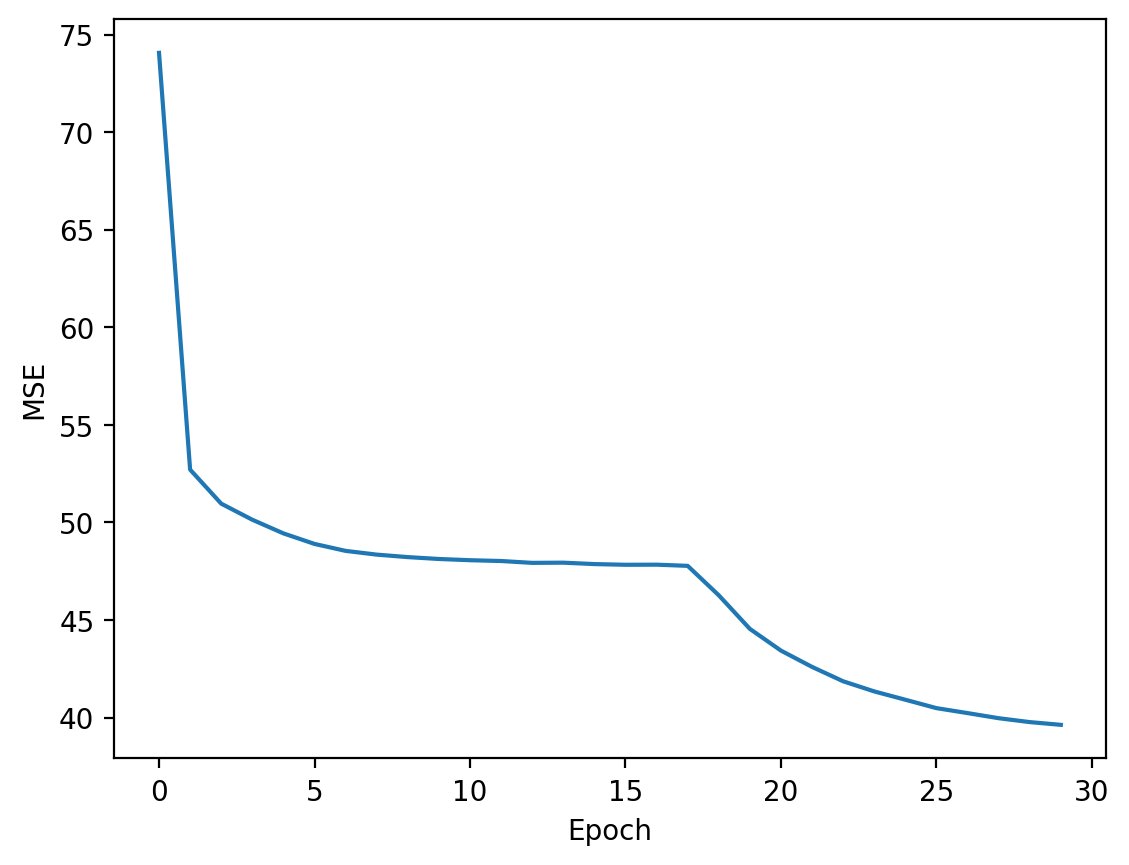

In [5]:
import platform
device = 'mps' if platform.system() == 'Darwin' else 'cpu'

dataloader = torch.utils.data.DataLoader(training_data_small, batch_size=128, shuffle=True)

autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters())

epoch_count = 30
losses = np.empty(epoch_count)

for epoch in range(epoch_count):
  autoencoder.train()
  epoch_loss = 0.0

  for x, _ in dataloader:
    optimizer.zero_grad()
    xp = x.to(device)

    # Calcul de la loss
    loss = ((autoencoder(xp) - xp) ** 2).sum()

    # Modification des poids
    loss.backward()
    optimizer.step()

    epoch_loss += loss.cpu().detach().numpy()

  losses[epoch] = epoch_loss / len(dataloader.dataset)

# Affichage de la loss au cours du temps
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE');


### Q4 (2pts)
Affichez une visualisation des représentations des données dans l'espace latent, c'est-à-dire en sortie de l'encodeur. Choisissez une couleur différente par classe.


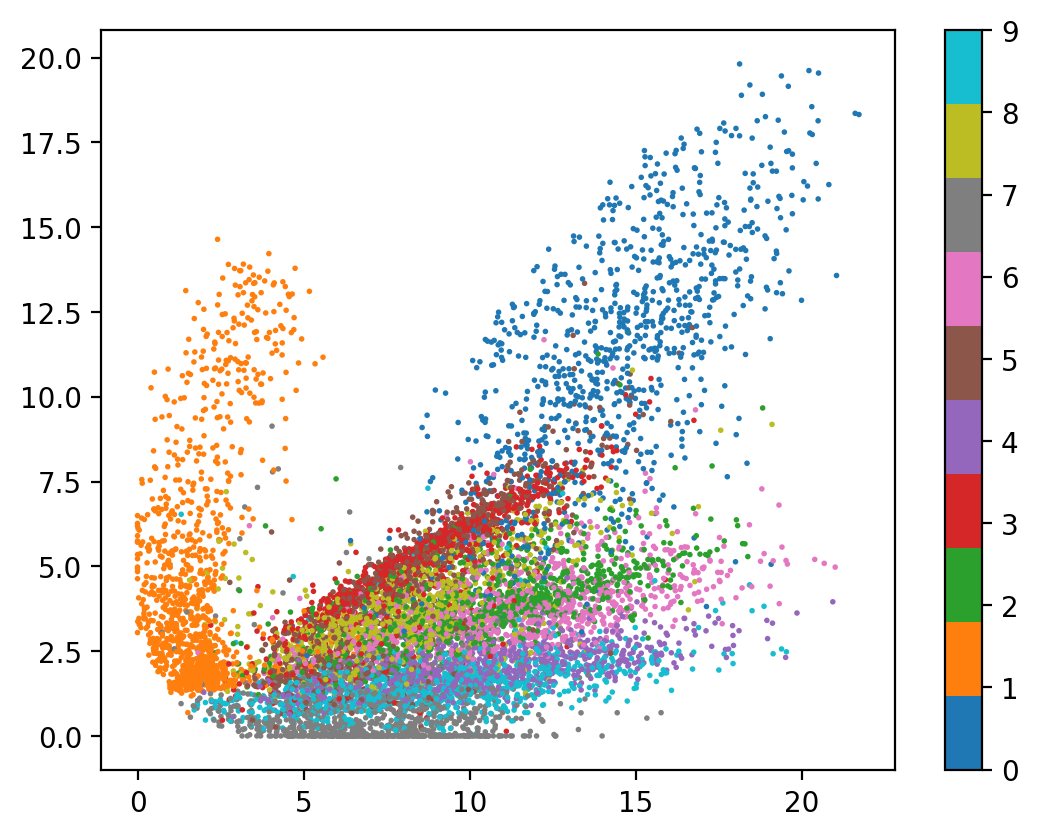

In [6]:
with torch.no_grad():
  autoencoder.eval()

  xs = torch.cat([x for x, _ in training_data_small]).to(device)
  ys = [y for _, y in training_data_small]

  # Calcul des variables latentes
  ls = autoencoder.encoder(xs).cpu()

fig, ax = plt.subplots()

im = ax.scatter(ls[:, 0], ls[:, 1], c=ys, s=1.0, cmap='tab10')
fig.colorbar(im);


### Q5 (2pts)
Trouvez un rectangle dans l'espace latent qui contient au moins 90 % des données et découpez ce carré en une grille
régulière de taille 10*10 (10 valeurs possibles en abscisse et 10 en ordonnée). Chaque nœud de cette grille 
est un vecteur de l'espace latent. Affichez les images générées par le décodeur à partir de ces points/nœuds 
dans le latent. Représentez les images en sortie du décodeur sous la forme d'un tableau facilement compréhensible.



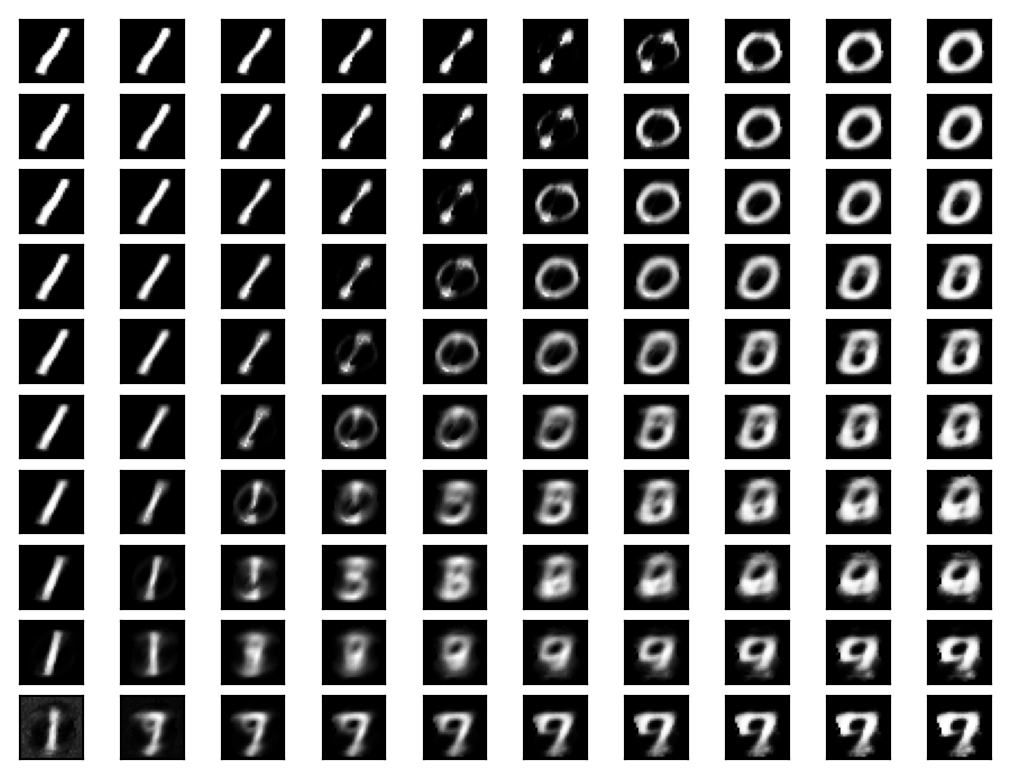

In [7]:
point_count = 10

# Calcul des points de la grille à intervalle régulier
# On utilise le type float32 pour le device MPS qui ne supporte pas float64
l0s = np.linspace(ls[:, 0].min(), ls[:, 0].max(), point_count, dtype=np.float32)

# On inverse min et max pour que ça corresponde à la visualisation au dessus
l1s = np.linspace(ls[:, 1].max(), ls[:, 1].min(), point_count, dtype=np.float32)

fig = plt.figure()

with torch.no_grad():
  for col, l0 in enumerate(l0s):
    for row, l1 in enumerate(l1s):
      x = autoencoder.decoder(torch.tensor([[l0, l1]]).to(device)).cpu().numpy().reshape(28, 28)

      ax = fig.add_subplot(point_count, point_count, 1 + col + row * point_count)
      ax.imshow(x, cmap='gray')
      ax.xaxis.set_visible(False)
      ax.yaxis.set_visible(False)


# Partie II: VAE

#### Q6 (8pts)

1)Implémentez un autoencodeur variationnel dont,

- l'encodeur est constitué en ce qui concerne la moyenne mu de :
  - un layer linéaire de taille de la dimension d'entrée et de sortie 128 avec une fonction d'activation ReLU
  - un layer linéaire de taille 128 en entrée

- l'encodeur est constitué en ce qui concerne l'écart type sigma de :
  - un layer linéaire de taille de la dimension d'entrée et de sortie 128 avec une fonction d'activation ReLU
  - un layer linéaire de taille 128 en entrée suivi d'une fonction exponentielle

Le premier layer du réseau pour mu et sigma peut être partagé, c'est-à-dire qu'ils partagent le meme premier layer.

Comme dans la Partie I :
- le décodeur est constitué de :
  - un layer linéaire de taille de sortie 128 avec une fonction d'activation ReLU
  - un layer linéaire de taille d'entrée 128 avec une sigmoide


Indication : vous pouvez vous aider du document 'rappel.pdf' pour implémenter le VAE.


2)Faites des batch de taille 128 et entraînez votre autoencodeur pendant 30 epochs avec comme loss la Mean Square Error. Représentez l'évolution de la loss au cours de l'entraînement. Vous êtes libre de choisir la régularisation que vous souhaitez.




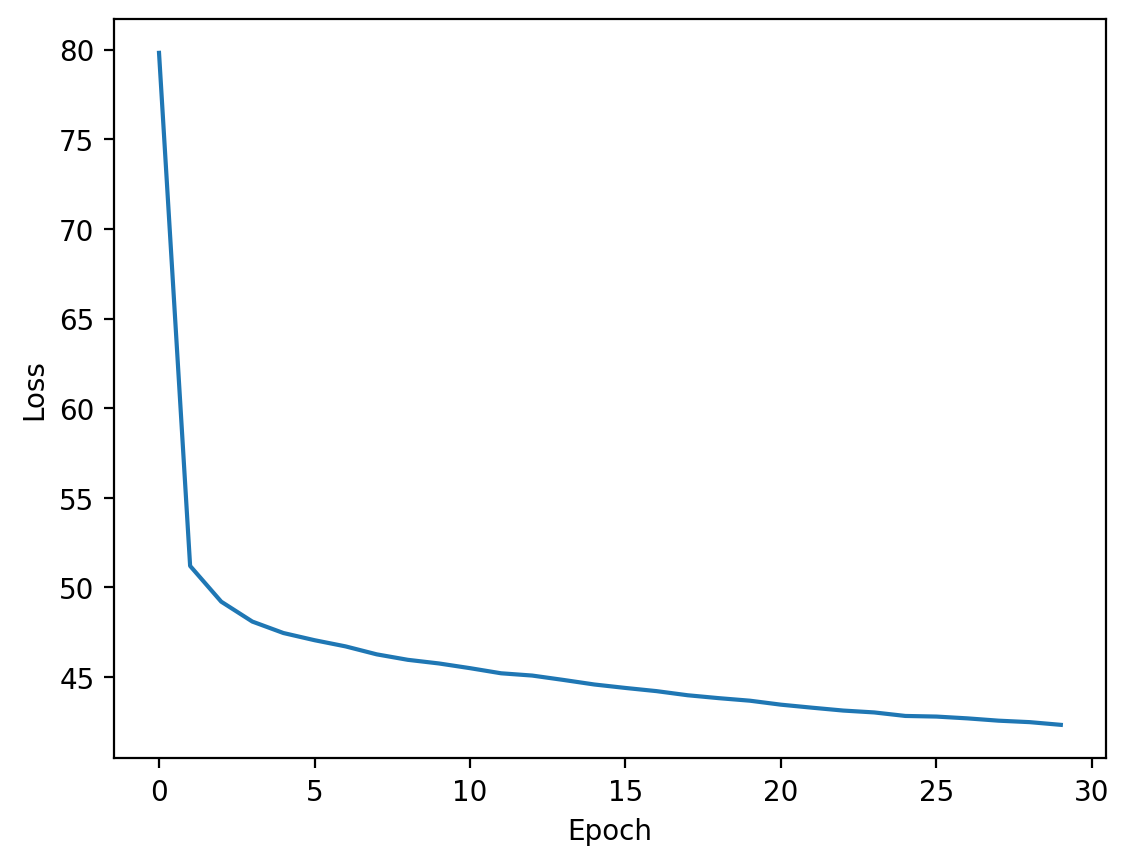

In [8]:
class VariationalAutoencoder(nn.Module):
  def __init__(self):
    super().__init__()

    # Couche partagée entre mu et sigma
    self.encoder_shared = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28, 128),
      nn.ReLU()
    )

    self.encoder_mu = nn.Sequential(
      nn.Linear(128, 2),
      nn.ReLU()
    )

    self.encoder_sigma = nn.Linear(128, 2)

    # Même décodeur
    self.decoder = nn.Sequential(
      nn.Linear(2, 128),
      nn.ReLU(),
      nn.Linear(128, 28 * 28),
      nn.Sigmoid(),
      nn.Unflatten(1, (1, 28, 28)),
    )

    self.normal = torch.distributions.Normal(0, 1)
    self.normal.loc = self.normal.loc.to(device)
    self.normal.scale = self.normal.scale.to(device)

    self.kl = 0

  def encoder(self, x: torch.Tensor):
    # Calcul de la première couche partagée
    encoded_shared = self.encoder_shared(x)

    # Calcul des valeurs de mu et sigma
    sigma = torch.exp(self.encoder_sigma(encoded_shared))
    mu =  self.encoder_mu(encoded_shared)

    # Échantillonage selon la distribution normale
    z = mu + sigma * self.normal.sample(mu.shape)

    # Calcul de la KL divergence
    self.kl = (-torch.log(sigma) + 0.5 * sigma**2 + 0.5 * mu**2 - 0.5).sum()

    return z

  def forward(self, x: torch.Tensor):
    return self.decoder(self.encoder(x))


vae = VariationalAutoencoder().to(device)
optimizer = torch.optim.Adam(vae.parameters())

epoch_count = 30
lambda_ = 0.01 # Contribution de la KL divergence dans la loss

losses = np.empty(epoch_count)

for epoch in range(epoch_count):
  vae.train()
  epoch_loss = 0.0

  for x, _ in dataloader:
    optimizer.zero_grad()
    xp = x.to(device)

    # Calcul de la loss due à la mauvaise reconstruction
    loss_def = ((vae(xp) - xp) ** 2).sum()

    # Calcul de la KL divergence
    loss = loss_def + lambda_ * vae.kl

    # Modification des poids
    loss.backward()
    optimizer.step()

    epoch_loss += loss.cpu().detach().numpy()

  losses[epoch] = epoch_loss / len(dataloader.dataset)

# Affichage de la loss au cours du temps
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss');


# Partie III: Classification

### Q (3pts)
Exploitez les représentations compressées des images données par les encodeurs de la première partie et de la seconde partie (VAE) pour entraîner un perceptron à deux couches, chaque couche étant un réseau linéaire avec ReLU. On veut entraîner seulement ces deux couches supplémentaires sans modifier les poids de l'encodeur. Comparez les accuracy sur le jeu de données test des deux encodeurs.

Indicate that some weights can be frozen (no gradient descent over those weights) with the following command

```python
 param.requires_grad = False
 ````


In [9]:
# Création d'un DataLoader pour les données de test
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

def classify(ae):
  class Classifier(nn.Module):
    def __init__(self):
      super().__init__()

      self.sequence = nn.Sequential(
        nn.Linear(2, 128),
        nn.ReLU(),
        nn.Linear(128, 10), # Une sortie par classe
        nn.Softmax(dim=1)
      )

    def forward(self, x: torch.Tensor):
      return self.sequence(x)

  # Gel des poids de l'autoencodeur
  ae.requires_grad_(False)

  classifier = Classifier().to(device)
  optimizer = torch.optim.Adam(classifier.parameters())

  epoch_count = 30

  accuracies = np.empty((epoch_count, 2))
  losses = np.empty(epoch_count)

  for epoch in range(epoch_count):
    classifier.train()

    epoch_acc_train = 0.0
    epoch_loss = 0.0

    for x, y in dataloader:
      optimizer.zero_grad()

      xp = x.to(device)
      yp = y.to(device)

      # Calcul des variables latentes
      xl = ae.encoder(xp)

      # Prédiction
      y_pred = classifier(xl)

      # Calcul des loss et accuracy
      acc = (y_pred.argmax(dim=1) == yp).sum()
      loss = F.cross_entropy(y_pred, yp)

      # Modification des poids
      loss.backward()
      optimizer.step()

      epoch_acc_train += acc.cpu().detach().numpy()
      epoch_loss += loss.cpu().detach().numpy()

    epoch_acc_test = 0.0

    # Évalution sur les données de test
    with torch.no_grad():
      for x, y in test_dataloader:
        xp = x.to(device)
        yp = y.to(device)

        xl = ae.encoder(xp)
        y_pred = classifier(xl)

        acc_test = (y_pred.argmax(dim=1) == yp).sum()
        epoch_acc_test += acc_test.cpu().detach().numpy()

    accuracies[epoch, 0] = epoch_acc_train / len(dataloader.dataset)
    accuracies[epoch, 1] = epoch_acc_test / len(test_dataloader.dataset)
    losses[epoch] = epoch_loss / len(dataloader.dataset)

  fig, ax = plt.subplots()

  ax.plot(accuracies[:, 0], label='Training')
  ax.plot(accuracies[:, 1], label='Test')

  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')

  ax.legend();


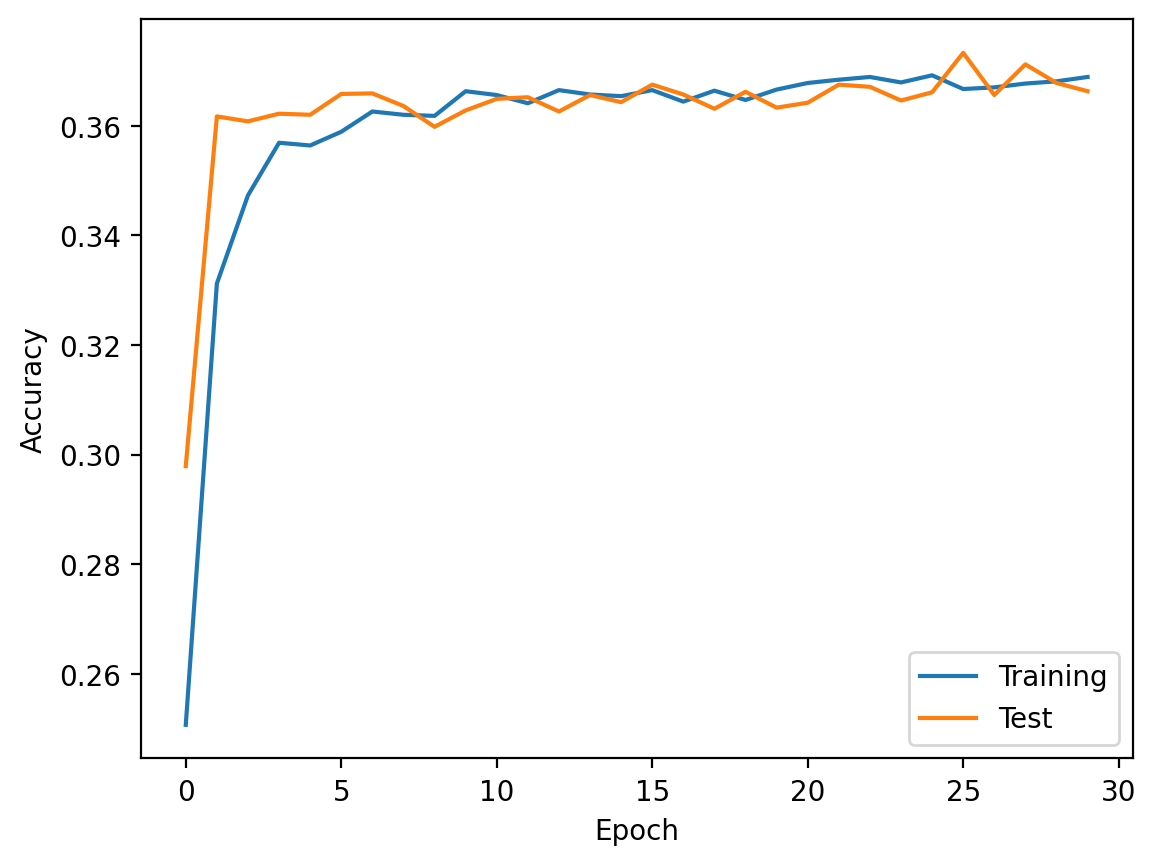

In [10]:
classify(autoencoder)


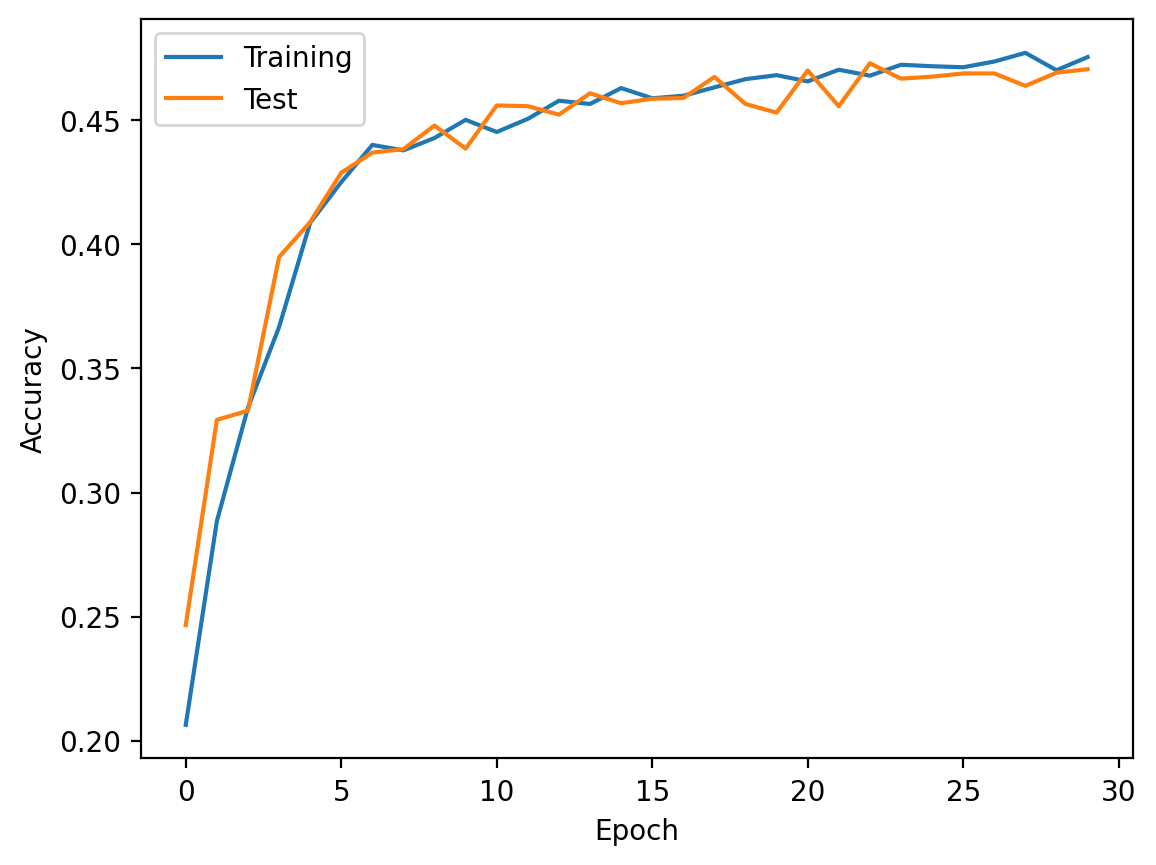

In [11]:
classify(vae)
